## Import

In [5]:
import sqlite3
import psycopg2
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine, inspect
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


## Connect to the database

In [2]:
# Database connection details
username = 'postgres'
password = 'password'
host = 'localhost'
port = '5432'
database = 'customer_db'

# Create the database connection string
connection_string = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"

# Create the engine
engine = create_engine(connection_string)

# Create an inspector
inspector = inspect(engine)

# Get table names
tables = inspector.get_table_names()
print("Available tables:", tables)

# Get table names
tables = inspector.get_table_names()
print("Available tables:", tables)

# Function to get all data from all tables
def get_all_data_from_tables(engine, tables):
    data_frames = {}
    with engine.connect() as connection:
        for table in tables:
            query = f"SELECT * FROM {table}"
            data_frames[table] = pd.read_sql(query, connection)
    return data_frames

# Retrieve all data from all tables
customer_db = get_all_data_from_tables(engine, tables)

# Close the engine
engine.dispose()

print(customer_db.keys())
customers = customer_db['customers']
orders = customer_db['orders']
customer_loyalty = customer_db['customer_loyalty']
loyalty_programs = customer_db['loyalty_programs']

Available tables: ['customers', 'orders', 'order_brands', 'brands', 'customer_loyalty', 'loyalty_programs']
Available tables: ['customers', 'orders', 'order_brands', 'brands', 'customer_loyalty', 'loyalty_programs']
dict_keys(['customers', 'orders', 'order_brands', 'brands', 'customer_loyalty', 'loyalty_programs'])


## RFM Analysis (Recency, Frequency, Monetary)
* Calculate Recency (days since last purchase), Frequency (total number of purchases), and Monetary (total spending) for each customer.
* Segment customers based on these scores.

,customer_id,recency,frequency,monetary,R,F,M,rfm_score,segment
0,1,24,7,504.12,3,2,1,321,Other
1,2,197,4,481.49,1,1,1,111,Other
2,3,3,4,502.12,3,1,1,311,New Customer
3,4,7,6,604.87,3,1,3,313,Other
4,5,75,7,525.33,2,2,2,222,Other
5,6,87,6,571.50,2,1,2,212,Other
6,7,24,10,848.52,3,3,3,333,Champion
7,8,1,7,578.95,3,2,2,322,Potential Loyalist
8,9,34,10,872.23,2,3,3,233,Other
9,10,27,6,558.72,2,1,2,212,Other


<Axes: xlabel='count', ylabel='segment'>

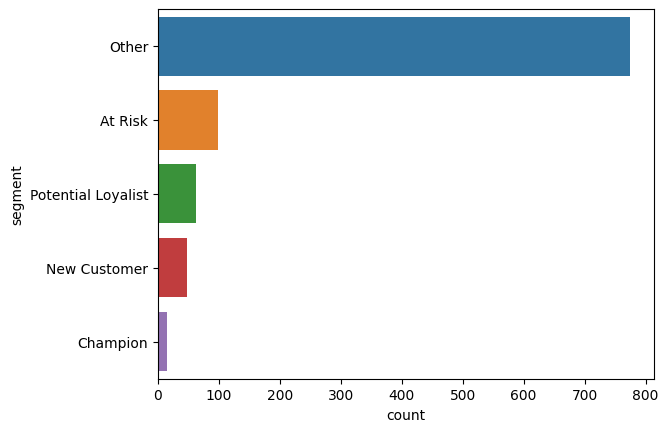

In [3]:
# Convert order_date to datetime format
orders['order_date'] = pd.to_datetime(orders['order_date'])

# Calculate Recency, Frequency, and Monetary values
# Define the current date for recency calculation
current_date = orders['order_date'].max() + pd.Timedelta(days=1)

# Calculate Recency: days since last purchase
recency = orders.groupby('customer_id').order_date.max().reset_index()
recency['recency'] = (current_date - recency['order_date']).dt.days
recency.drop(columns='order_date', inplace=True)

# Calculate Frequency: total number of orders
frequency = orders.groupby('customer_id').order_id.count().reset_index()
frequency.columns = ['customer_id', 'frequency']

# Calculate Monetary: total amount spent
monetary = orders.groupby('customer_id').total_amount.sum().reset_index()
monetary.columns = ['customer_id', 'monetary']

# Merge R, F, and M dataframes into a single dataframe
rfm = recency.merge(frequency, on='customer_id').merge(monetary, on='customer_id')

quantiles = rfm[['recency', 'frequency', 'monetary']].quantile([0.33, 0.66]).to_dict()

# Define a function to calculate RFM scores
def rfm_score(x, q_dict, column_name, reverse=False):
    if reverse:  # Reverse scoring for recency
        if x <= q_dict[column_name][0.33]:
            return 3
        elif x <= q_dict[column_name][0.66]:
            return 2
        else:
            return 1
    else:
        if x <= q_dict[column_name][0.33]:
            return 1
        elif x <= q_dict[column_name][0.66]:
            return 2
        else:
            return 3

# Apply RFM score calculations
rfm['R'] = rfm['recency'].apply(rfm_score, args=(quantiles, 'recency', True))
rfm['F'] = rfm['frequency'].apply(rfm_score, args=(quantiles, 'frequency', False))
rfm['M'] = rfm['monetary'].apply(rfm_score, args=(quantiles, 'monetary', False))

# Combine RFM scores into a single score
rfm['rfm_score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

def segment_customer(df):
    if df['R'] == 3 and df['F'] == 3 and df['M'] == 3:
        return 'Champion'
    elif df['R'] == 3 and df['F'] == 1 and df['M'] == 1:
        return 'New Customer'
    elif df['R'] == 1 and df['F'] == 2:
        return 'At Risk'
    elif df['R'] == 3 and df['F'] == 2 and df['M'] == 2:
        return 'Potential Loyalist'
    else:
        return 'Other'

# Assign segments
rfm['segment'] = rfm.apply(segment_customer, axis=1)

display(rfm.head(20))

sns.countplot(data=rfm, y='segment', order=rfm['segment'].value_counts().index)

## K-Means Clustering

In [6]:
# Database connection parameters
host = 'localhost'
database = 'customer_db'
user = 'postgres'
password = 'password'

# Create a connection string
connection_string = f'postgresql://{user}:{password}@{host}/{database}'

# Create a SQLAlchemy engine
engine = create_engine(connection_string)

# Define your query
query = """
WITH customer_ages AS (
    SELECT 
        customer_id,
        EXTRACT(YEAR FROM AGE(birth_date)) AS age
    FROM customers
),
nike_loyalty AS (
    SELECT 
        cl.customer_id,
        TRUE AS is_nike
    FROM customer_loyalty cl
    JOIN loyalty_programs lp ON cl.program_id = lp.program_id
    WHERE lp.program_name = 'Nike'
),
polo_loyalty AS (
    SELECT 
        cl.customer_id,
        TRUE AS is_polo
    FROM customer_loyalty cl
    JOIN loyalty_programs lp ON cl.program_id = lp.program_id
    WHERE lp.program_name = 'Polo Ralph Lauren'
),
zign_loyalty AS (
    SELECT 
        cl.customer_id,
        TRUE AS is_zign
    FROM customer_loyalty cl
    JOIN loyalty_programs lp ON cl.program_id = lp.program_id
    WHERE lp.program_name = 'Zign'
),
order_stats AS (
    SELECT 
        customer_id,
        AVG(total_amount) AS avg_order_amount,
        COUNT(order_id) AS order_count
    FROM orders
    GROUP BY customer_id
)

SELECT 
    c.customer_id,
    COALESCE(ca.age, 0) AS age,
    COALESCE(nl.is_nike, FALSE) AS is_nike,
    COALESCE(pl.is_polo, FALSE) AS is_polo,
    COALESCE(zl.is_zign, FALSE) AS is_zign,
    COALESCE(os.avg_order_amount, 0.0) AS avg_order_amount,
    COALESCE(os.order_count, 0) AS order_count
FROM customers c
LEFT JOIN customer_ages ca ON c.customer_id = ca.customer_id
LEFT JOIN nike_loyalty nl ON c.customer_id = nl.customer_id
LEFT JOIN polo_loyalty pl ON c.customer_id = pl.customer_id
LEFT JOIN zign_loyalty zl ON c.customer_id = zl.customer_id
LEFT JOIN order_stats os ON c.customer_id = os.customer_id
;
"""

# Execute the query and load the results into a pandas DataFrame
customer_data = pd.read_sql_query(query, engine)

# Display the DataFrame
print(customer_data.head())

   customer_id   age  is_nike  is_polo  is_zign  avg_order_amount  order_count
0            1  30.0    False     True    False         92.031429            7
1            2  37.0    False     True    False        186.125000            4
2            3  46.0    False    False    False        166.582500            4
3            4  24.0    False    False    False         67.667143            7
4            5  29.0    False     True    False        169.760000            5


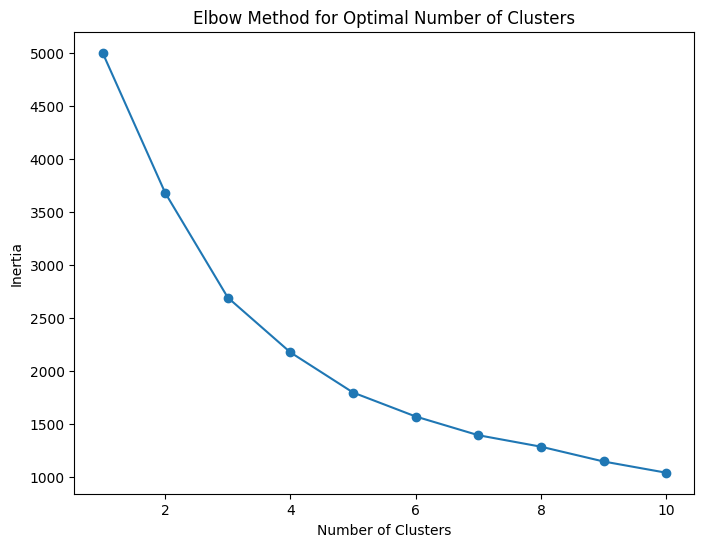

In [8]:
# Select the features to be used for clustering
features = customer_data[['age', 'is_nike', 'is_polo', 'avg_order_amount', 'order_count']].copy()

# Convert boolean columns to integers
features.loc[:, 'is_nike'] = features['is_nike'].astype(int)
features.loc[:, 'is_polo'] = features['is_polo'].astype(int)
#features.loc[:, 'is_zign'] = features['is_zign'].astype(int)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [9]:
# Based on the elbow plot, choose the optimal number of clusters
optimal_clusters = 3
# Perform k-means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['cluster'] = kmeans.fit_predict(scaled_features)

# Display the cluster centers and cluster assignments
print("Cluster Centers:")
print(kmeans.cluster_centers_)
print("Cluster Assignments:")
customer_data.head()

Cluster Centers:
[[-0.06074202  1.85592145 -0.15878552 -0.47023385  0.99295652]
 [ 0.19444133 -0.45659316  0.92930144  1.30897947 -1.1935079 ]
 [-0.05840693 -0.53881591 -0.33103778 -0.36900267  0.11384686]]
Cluster Assignments:


,customer_id,age,is_nike,is_polo,is_zign,avg_order_amount,order_count,cluster
0,1,30.0,False,True,False,92.031429,7,2
1,2,37.0,False,True,False,186.125000,4,1
2,3,46.0,False,False,False,166.582500,4,1
3,4,24.0,False,False,False,67.667143,7,2
4,5,29.0,False,True,False,169.760000,5,1


## Three customer segments were idenfied.
**Cluster 0:** Young customers who are part of the Nike loyalty program, places small but frequent orders.

**Cluster 1:** Older customers who are part of the Polo Ralph Lauren loyalty program, places large orders less frequently.

**Cluster 2:** No clear pattern, a mix of customers with varying characteristics.

**Note:** see README.md for the executive summary and actionable insights.


In [12]:
cluster_analysis = customer_data.groupby('cluster').agg(
    total_customers=('customer_id', 'count'),
    mdn_age=('age', 'median'),
    pct_is_nike=('is_nike', lambda x: (x.sum() / x.count()) * 100),
    pct_is_polo=('is_polo', lambda x: (x.sum() / x.count()) * 100),
    pct_is_zign=('is_zign', lambda x: (x.sum() / x.count()) * 100),
    mdn_avg_order_amount=('avg_order_amount', 'median'),
    mdn_order_count=('order_count', 'median')
).reset_index()

display(cluster_analysis)

,cluster,total_customers,mdn_age,pct_is_nike,pct_is_polo,pct_is_zign,mdn_avg_order_amount,mdn_order_count
0,0,217,28.0,100.000000,13.824885,5.529954,96.781429,7.0
1,1,233,32.0,3.433476,57.510730,12.017167,166.353333,4.0
2,2,550,29.0,0.000000,6.909091,6.000000,101.450000,7.0


## Nike loyalty program members aged <24 place more orders.

In [13]:
# Filter customers aged <24
under_24_customers = customer_data[customer_data['age'] < 24]

# Group by 'is_nike' and calculate the average order count
nike_order_comparison = under_24_customers.groupby('is_nike')['order_count'].mean().reset_index()

# Display the results
print(nike_order_comparison)

   is_nike  order_count
0    False     5.659193
1     True     7.956522
